# Advanced Modeling of Groundwater Flow (GW3099)
![alt text](./img/header.jpg)

# Exercise 4
The purpose of this exercise is to use MODFLOW 6 and the DISV package to simulate example problem 1 using a nested grid.

## Part I. Setup Notebook

In [2]:
%matplotlib inline
from __future__ import print_function
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import config

print(sys.version)
print('python executable: {}'.format(sys.executable))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
python executable: C:\Users\langevin\Anaconda3\python.exe
numpy version: 1.14.1
matplotlib version: 2.1.2
flopy version: 3.2.9


## Part II. Gridgen Creation of Model Grid

In [3]:
from flopy.utils.gridgen import Gridgen 

### Create the Base MODFLOW Grid

In [4]:
Lx = 10000.
Ly = 10500.
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

In [5]:
ms = flopy.modflow.Modflow(rotation=-20.)
dis5 = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

### Create the Gridgen Object

In [6]:
model_name = 'ex04'
model_ws = os.path.join('.', 'ex04-completed')
gridgen_ws = os.path.join(model_ws, 'gridgen')
g = Gridgen(dis5, model_ws=gridgen_ws, exe_name=config.gridgenexe)

### Refine the Grid

In [7]:
rf0shp = os.path.join(gridgen_ws, 'rf0')
xmin = 7 * delr
xmax = 12 * delr
ymin = 8 * delc
ymax = 13 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 1, range(nlay))

rf1shp = os.path.join(gridgen_ws, 'rf1')
xmin = 8 * delr
xmax = 11 * delr
ymin = 9 * delc
ymax = 12 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 2, range(nlay))

rf2shp = os.path.join(gridgen_ws, 'rf2')
xmin = 9 * delr
xmax = 10 * delr
ymin = 10 * delc
ymax = 11 * delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 3, range(nlay))

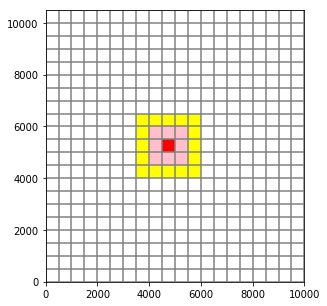

In [8]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.ModelMap(model=ms)
mm.plot_grid()
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='yellow', edgecolor='none')
flopy.plot.plot_shapefile(rf1shp, ax=ax, facecolor='pink', edgecolor='none')
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='red', edgecolor='none')

In [9]:
g.build(verbose=False)

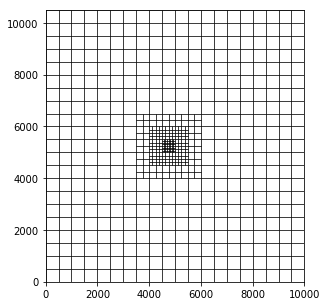

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)

### Extract the Grid Properties

In [11]:
gridprops = g.get_gridprops_disv()
#gridprops

In [12]:
ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert']
vertices = gridprops['vertices']
cell2d = gridprops['cell2d']
cellxy = gridprops['cellxy']

## Part III. Create the Flopy Model

In [13]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name='mf6', 
                             sim_ws=model_ws)

# create tdis package
tdis_rc = [(1000.0, 1, 1.0)]
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-5, 
                           outer_maximum=100, under_relaxation='NONE', 
                           inner_maximum=100, inner_hclose=1.e-6, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)
sim.register_ims_package(ims, [gwf.name])

# disv
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, 
                                top=top, botm=botm, 
                                nvert=nvert, vertices=vertices, 
                                cell2d=cell2d)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=320.)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[('xt3d')], 
                              icelltype=[1,0,0], 
                              k=[50.0, 0.01, 200.0],
                              k33=[10., 0.01, 20.])

# wel
wellpoints = [(4750., 5250.)]
welcells = g.intersect(wellpoints, 'point', 0)
#welspd = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf, maxbound=1, aux_vars=['iface'])
welspd = [[(2, icpl), -150000, 0] for icpl in welcells['nodenumber']]
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True,
                              auxiliary=[('iface', )],
                              stress_period_data=welspd)

# rch
aux = [np.ones(ncpl, dtype=np.int)*6]
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005, 
                               auxiliary=[('iface',)], 
                               aux={0: [6]})
# riv
riverline = [[[(Lx - 1., Ly), (Lx - 1., 0.)]]]
rivcells = g.intersect(riverline, 'line', 0)
rivspd = [[(0, icpl), 320., 100000., 318] for icpl in rivcells['nodenumber']]
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)

# output control
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbb'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

sim.write_simulation()

Directory structure already exists for simulation path Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\MODFLOW6\.\ex04-completed
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model ex04...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...


## Part III. Run the MODFLOW 6 Model

In [14]:
sim.run_simulation()

FloPy is using the following  executable to run the model: Z:\langevin\bin\win\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.3 08/09/2018

   MODFLOW 6 compiled Aug 09 2018 13:40:32 with IFORT compiler (ver. 18.0.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Reso

(True, [])

## Part IV. Import and Plot the Results

### Plot the Boundary Locations

In [15]:
fname = os.path.join(model_ws, model_name + '.disv.grb')
grd = flopy.utils.MfGrdFile(fname, verbose=False)
iverts, verts = grd.get_verts()
vertc = grd.get_centroids()
xc = vertc[:, 0]
yc = vertc[:, 1]
sr = flopy.utils.reference.SpatialReferenceUnstructured(xc, yc, verts, iverts, [xc.shape[0]])

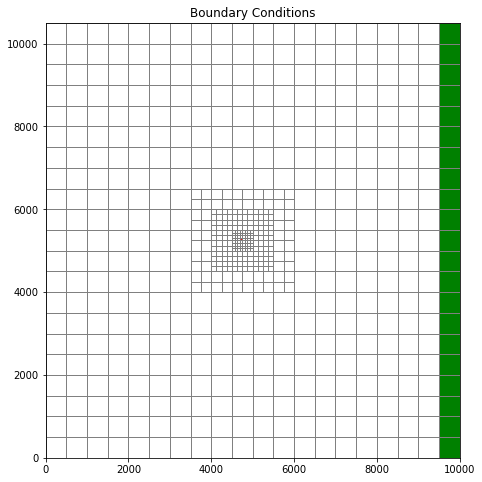

In [16]:
ibd = np.zeros((ncpl), dtype=np.int)
ibd[welcells['nodenumber']] = 1
ibd[rivcells['nodenumber']] = 2
ibd = np.ma.masked_equal(ibd, 0)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.ModelMap(sr=sr, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(['r','g',])
v = mm.plot_cvfd(verts, iverts, edgecolor='gray', a=ibd, cmap=cmap)
t = ax.set_title('Boundary Conditions')

In [17]:
fname = os.path.join(model_ws, model_name + '.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
head.shape

(3, 1, 651)

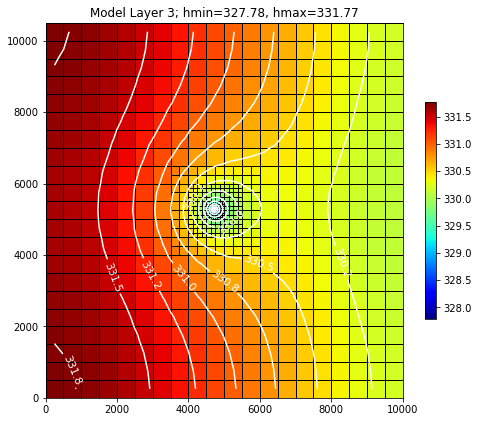

In [18]:
ilay = 2
cint = .25
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.ModelMap(sr=sr, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
v = mm.plot_cvfd(verts, iverts, edgecolor='black', a=head[ilay, 0, :], cmap='jet')
hmin = head[ilay, 0, :].min()
hmax = head[ilay, 0, :].max()
levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array_cvfd(vertc, head[ilay, 0, :], colors='white', 
                           levels=levels)
plt.clabel(cs, fmt='%.1f', colors='white', fontsize=11)
cb = plt.colorbar(v, shrink=0.5)
t = ax.set_title('Model Layer {}; hmin={:6.2f}, hmax={:6.2f}'.format(ilay + 1, hmin, hmax))

### Model Cells and Vertices

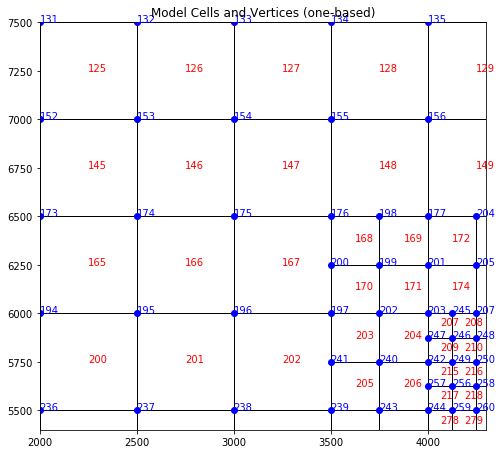

In [19]:
# zoom area
xmin, xmax = 2000, 4300
ymin, ymax = 5400, 7500

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.ModelMap(sr=sr, ax=ax)
v = mm.plot_cvfd(verts, iverts, edgecolor='black', facecolor='none')
t = ax.set_title('Model Cells and Vertices (one-based)')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.plot(verts[:, 0], verts[:, 1], 'bo')

for i in range(nvert):
    x = verts[i, 0]
    y = verts[i, 1]
    if xmin <= x <= xmax and ymin <= y <= ymax:
        ax.annotate(str(i + 1), verts[i, :], color='b')
        
for i in range(ncpl):
    x = vertc[i, 0]
    y = vertc[i, 1]
    if xmin <= x <= xmax and ymin <= y <= ymax:
        ax.annotate(str(i + 1), vertc[i, :], color='r')    

(3,)